In [84]:
import warnings
from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
from finrl.meta.preprocessor.preprocessors import data_split
from finrl.agents.stablebaselines3.models import DRLAgent
from feature_engineer import FeatureEngineer
from models import DRLAgent
from portfolio_optimization_env import PortfolioOptimizationEnv
import sys
import scienceplots
sys.path.append("../FinRL-Library")
plt.style.use('science')

from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
)
from pypfopt import expected_returns

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

def DRL_prediction(model, environment,time_window, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    # state_memory=[] #add memory pool to store states

    test_env.reset()
    max_steps = len(environment._df.index.unique()) - (time_window) - 1

    for i in range(len(environment._df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        test_obs, rewards, dones, info = test_env.step(action)
        if i == max_steps:  
            date_list = environment._date_memory
            portfolio_return = environment._portfolio_return_memory
            df_account_value = pd.DataFrame(
                {"date": date_list, "daily_return": portfolio_return,'account' :  environment._asset_memory["final"],'weights':environment._final_weights}
            )
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = environment._actions_memory
            df_actions = pd.DataFrame(action_list)
            tiks = environment._tic_list
            df_actions.columns = np.insert(tiks,0,'POS')
            df_actions.index = df_date.date
            account_memory = df_account_value
            actions_memory = df_actions

        if dones[0]:
            print("hit end!")
            break
    return account_memory, actions_memory
DATA_START_DATE ='2016-01-01'
TRAIN_START_DATE = '2017-01-01'
TRAIN_END_DATE = '2022-12-30'
TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-12-15'
from pandas import read_csv


df_dow =read_csv('./data/dow.csv')
df_nasdaq =read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')
def mvo_data(data, INDICATORS, TEST_START_DATE, TEST_END_DATE):
    final_result = []
    df = data.sort_values(['date', 'tic'], ignore_index=True).copy()
    df.index = df.date.factorize()[0]
    cov_list = []
    mu = []
    # look back is one year
    lookback = 252
    for i in range(lookback, len(df.index.unique())):
        data_lookback = df.loc[i-lookback:i, :]
        price_lookback = data_lookback.pivot_table(
            index='date', columns='tic', values='close')
        return_lookback = price_lookback.pct_change().dropna()
        covs = return_lookback.cov().values
        mu.append(expected_returns.mean_historical_return(price_lookback))
        cov_list.append(covs)
    df_cov = pd.DataFrame(
        {'time': df.date.unique()[lookback:], 'cov_list': cov_list, 'returns': mu})
    df = df.merge(df_cov, left_on='date', right_on='time')

    test_df = data_split(
        df,
        start=TEST_START_DATE,
        end=TEST_END_DATE
    )
    return test_df
def mvo(data, solver='OSQP', rf=0.02, pct=0.001,objective='min_variance'):
    result = {}
    stock_dimension = len(data.tic.unique())
    state_space = stock_dimension
    env_kwargs = {
        "hmax": 100,
        "initial_amount": 50_000,
        "transaction_cost_pct": pct,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4

    }
    e_test_gym = StockPortfolioEnv(df=data, **env_kwargs)
    agent = MarkowitzAgent(e_test_gym, rf=rf,objective=objective)
    mvo_min_variance = agent.prediction(e_test_gym)
    mvo_min_variance["method"] = "markowitz"
    mvo_min_variance.columns = ['date', 'account', 'return', 'method']
    result["test"] = mvo_min_variance
    result["name"] = 'Min Variance Portfolio'
    return result
    

# DOW

In [2]:
INDICATORS = [
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df_dow[df_dow["date"] > DATA_START_DATE])
data = processed_dax.copy()
data = data.fillna(0)
data = data.replace(np.inf,0)
train_data = data_split(data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(data, TEST_START_DATE, TEST_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 29, State Space: 88


In [9]:
covs = mvo_data(df_dow,INDICATORS,TEST_START_DATE,TEST_END_DATE)


In [10]:
mvo_result = mvo(covs,pct=0.01)

begin_total_asset:50000
end_total_asset:53881.82021079593
Sharpe:  0.4632628322531071
Test Finished!
episode_return 1.0776364042159186


In [11]:
mvo_result_max = mvo(covs,objective='sharpe',pct=0.01)

begin_total_asset:50000
end_total_asset:59197.222213084206
Sharpe:  0.7487136852591536
Test Finished!
episode_return 1.1839444442616842


In [88]:
def train_model(train_data,test_data,transaction_fee=0.001,use_sharpe=False,use_sortino=False,model_name='a2c'
                ,iterations = 50000,save=True,load=False,tag='tag',features=["close","log_return"],t=5):

    env_kwargs = {
        "initial_amount": 8000, 
        "normalize_df":None,
        "features" :features,
        'comission_fee_pct':transaction_fee,
        'time_window':t,
        'use_sharpe':use_sharpe,
        'use_sortino':use_sortino,
    }
    train_environment = PortfolioOptimizationEnv(df = train_data, **env_kwargs)
    env_kwargs = {
        "initial_amount": 8000, 
        "normalize_df":None,
        'comission_fee_pct':transaction_fee,
        "features" :features,
        'time_window':t,
        'use_sharpe':use_sharpe,
        'use_sortino':use_sortino,
    }

    test_environment = PortfolioOptimizationEnv(df = test_data, **env_kwargs)
    agent = DRLAgent(env = train_environment)
    model_agent = agent.get_model(model_name,
                                  verbose=0,
                                model_kwargs = None)

    
    if not load:
        model = agent.train_model(model=model_agent, 
                                    tb_log_name=model_name,
                                    total_timesteps=iterations)
    else:
        print('loading model')
        model = model_agent.load('./data/trained_models/'+str(model_name)+'_'+str(iterations)+'_' + tag,env =train_environment)
    if save and not load:
        model.save('./data/trained_models/'+str(model_name)+'_'+str(iterations)+'_' + tag )
    metrics_df_dax = pd.DataFrame(
        {
            "date": train_environment._date_memory,
            "actions": train_environment._actions_memory,
            "weights": train_environment._final_weights,
            "returns": train_environment._portfolio_return_memory,
            "rewards": train_environment._portfolio_reward_memory,
            "portfolio_values": train_environment._asset_memory["final"],
        }
    )
    ppo_predictions = DRL_prediction(model_agent, test_environment,t)
    results = {'train': metrics_df_dax,'test':ppo_predictions, 'model': model_agent}
    return results

In [46]:
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=1000,model_name='ddpg',save=True)
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=1000,save=True)
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=1000,save=True)
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,model_name='td3',iterations=1000,save=True)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Initial portfolio value:1000000
Final portfolio value: 1310483.875
Final accumulative portfolio value: 1.310483875
Maximum DrawDown: -0.08285934782279636
Sharpe ratio: 1.456735224187834
hit end!
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/              |             |
|    fps             | 52          |
|    iterations      | 1           |
|    time_elapsed    | 38          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.013705201 |
------------------------------------
Initial portfolio value:1000000
Final portfolio value: 1255194.125
Final accumulative portfolio value: 1.255194125
Maximum DrawDown: -0.

In [29]:
iterations = 10_000
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',save=False)
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=iterations,save=False)
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=iterations,save=False)
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,model_name='td3',iterations=iterations,save=False)

Initial portfolio value:8000
Final portfolio value: 11463.6416015625
Final accumulative portfolio value: 1.4329552001953125
Maximum DrawDown: -0.32207052297871597
Sharpe ratio: 0.2500618862343456
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 3.27e+03     |
|    ep_rew_mean          | 0.371        |
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 2            |
|    time_elapsed         | 99           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.010997624  |
|    clip_fraction        | 0.0914       |
|    clip_range           | 0.2          |
|    entropy_loss         | -42.6        |
|    explained_variance   | -1.38        |
|    learning_rate        | 0.00025      |
|    loss                 | -0.459       |
|    n_updates            | 10           |
|    policy_gradient_loss | -0

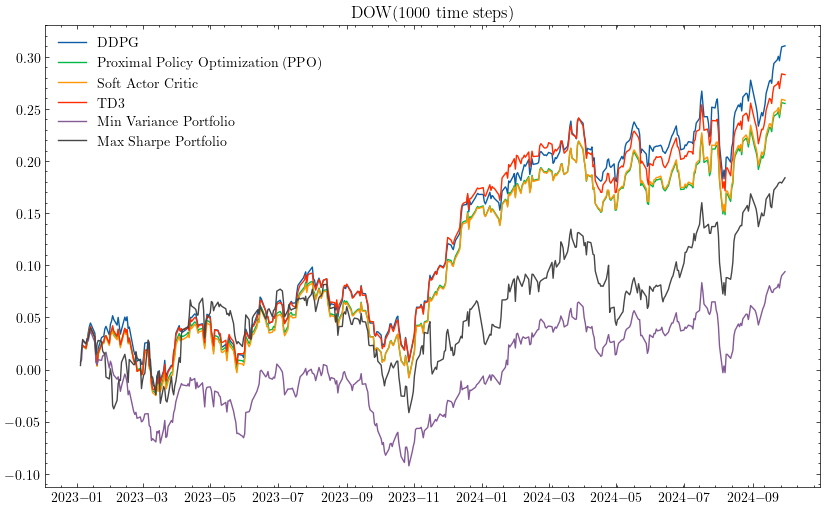

In [48]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test_df'][0].get('date'),(result_ddpg['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test_df'][0].get('date'),(result_ppo['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test_df'][0].get('date'),(result_sac['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test_df'][0].get('date'),(result_td3['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(mvo_result['test'].get('date'),(mvo_result['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(mvo_result_max['test'].get('date'),(mvo_result_max['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DOW(1000 time steps)')

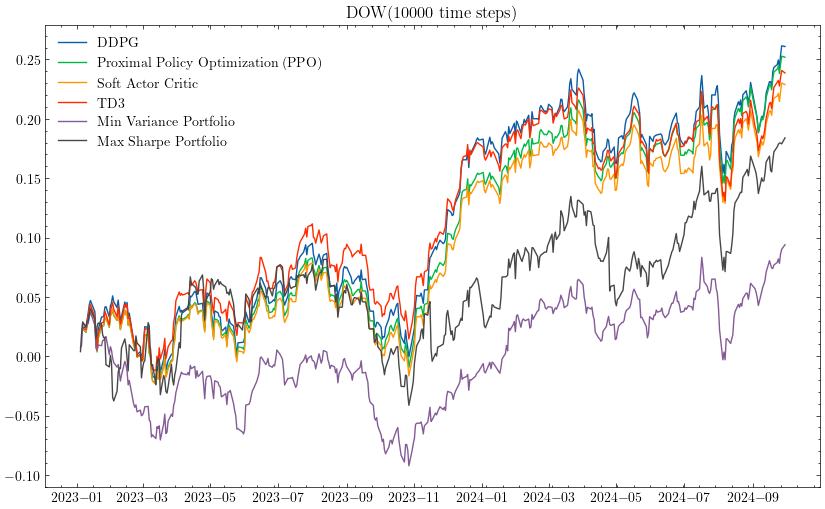

In [43]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test_df'][0].get('date'),(result_ddpg['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test_df'][0].get('date'),(result_ppo['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test_df'][0].get('date'),(result_sac['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test_df'][0].get('date'),(result_td3['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(mvo_result['test'].get('date'),(mvo_result['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(mvo_result_max['test'].get('date'),(mvo_result_max['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DOW(10000 time steps)')

In [49]:
iterations = 30_000
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',save=True,tag='dow30')
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=iterations,save=True,tag='dow30')
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=iterations,save=True,tag='dow30')
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,model_name='td3',iterations=iterations,save=True,tag='dow30')

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Initial portfolio value:8000
Final portfolio value: 44217.9765625
Final accumulative portfolio value: 5.5272470703125
Maximum DrawDown: -0.3114089275408628
Sharpe ratio: 0.8979783301491956
Initial portfolio value:8000
Final portfolio value: 44523.99609375
Final accumulative portfolio value: 5.56549951171875
Maximum DrawDown: -0.3274275540525047
Sharpe ratio: 0.8830368983570219
Initial portfolio value:8000
Final portfolio value: 43535.859375
Final accumulative portfolio value: 5.441982421875
Maximum DrawDown: -0.3141870522438056
Sharpe ratio: 0.8772791841582078
Initial portfolio value:8000
Final portfolio value: 42755.125
Final accumulative portfolio value: 5.344390625
Maximum DrawDown: -0.3056047763254146
Sharpe ratio: 0.8758619346451
------------------------------------
| rollout/           |             |
|    ep_len_mean    

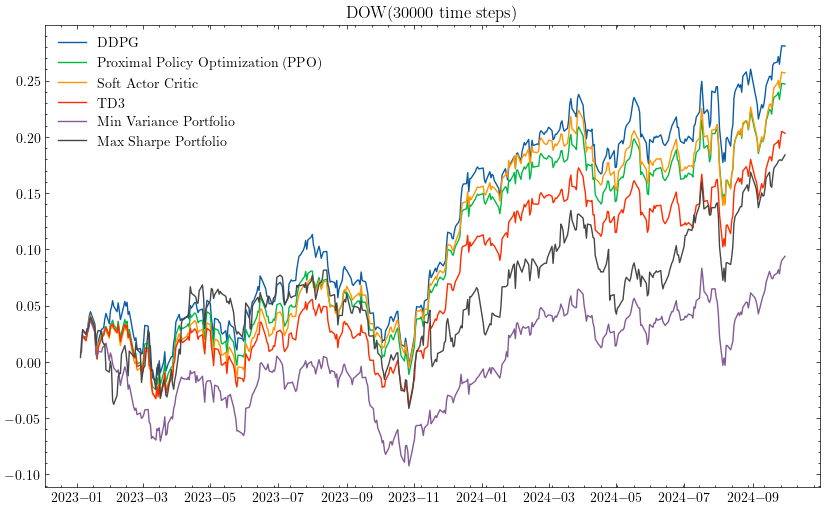

In [50]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test_df'][0].get('date'),(result_ddpg['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test_df'][0].get('date'),(result_ppo['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test_df'][0].get('date'),(result_sac['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test_df'][0].get('date'),(result_td3['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(mvo_result['test'].get('date'),(mvo_result['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(mvo_result_max['test'].get('date'),(mvo_result_max['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DOW(30000 time steps)')

In [ ]:
iterations = 60_000
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',save=True,tag='dow30')
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=iterations,save=True,tag='dow30')
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=iterations,save=True,tag='dow30')
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,model_name='td3',iterations=iterations,save=True,tag='dow30')

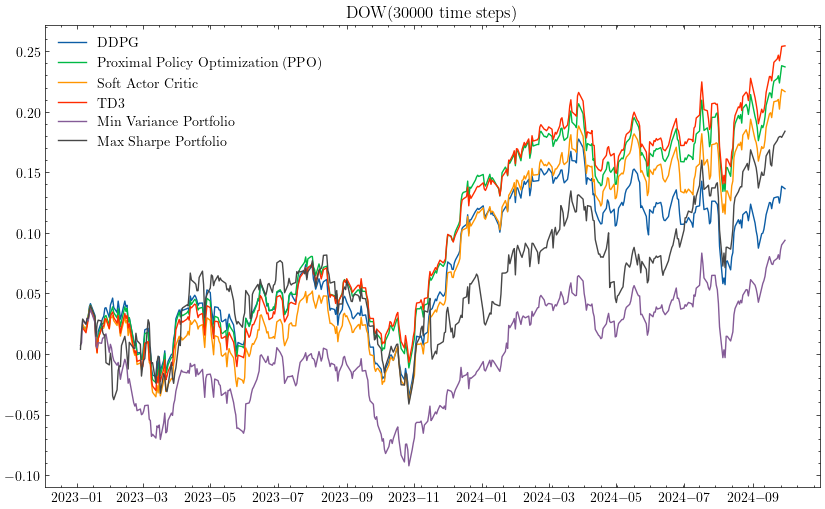

In [52]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test_df'][0].get('date'),(result_ddpg['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test_df'][0].get('date'),(result_ppo['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test_df'][0].get('date'),(result_sac['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test_df'][0].get('date'),(result_td3['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(mvo_result['test'].get('date'),(mvo_result['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(mvo_result_max['test'].get('date'),(mvo_result_max['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DOW(30000 time steps)')

In [115]:
result_sac = train_model(train_data,train_data,transaction_fee=0.001,model_name='sac',iterations=1_000_000,load=True,tag='dow30')

{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 16350.5009765625
Final accumulative portfolio value: 2.0438126220703126
hit end!


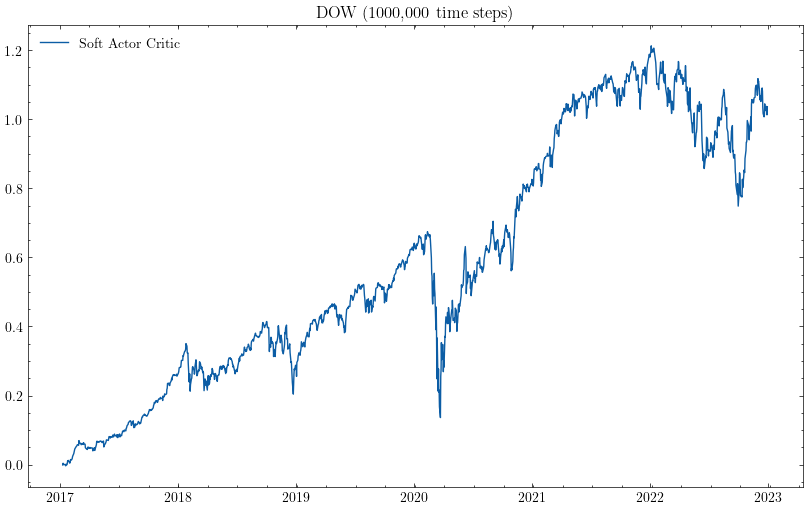

In [79]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_sac['test_df'][0].get('date'),(result_sac['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')

    plt.legend()
    plt.title('DOW (1000,000 time steps)')

In [113]:
len(train_data.tic.unique().tolist())


29

In [120]:
weights = pd.DataFrame(result_sac['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.insert(0,'Cash')
weights.columns = columns
columns.append('date')
weights['date'] = result_sac['test'][0].date
# weights["sum"] = weights.drop(columns=["date"]).sum(axis=1)
weights

,Cash,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT,date
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017-01-09
1,0.032191,0.034153,0.034244,0.033971,0.034971,0.033546,0.034559,0.034086,0.033778,0.034174,...,0.032560,0.033517,0.032666,0.032472,0.033983,0.032580,0.032145,0.033414,0.032884,2017-01-10
2,0.031988,0.034094,0.033579,0.033554,0.034690,0.033126,0.035197,0.033385,0.034087,0.034343,...,0.032654,0.033221,0.032940,0.032453,0.033930,0.032757,0.031774,0.033904,0.033081,2017-01-11
3,0.032275,0.034078,0.034077,0.033675,0.034667,0.032883,0.034393,0.033817,0.034174,0.033681,...,0.032364,0.033579,0.033160,0.032357,0.034251,0.032671,0.032340,0.033282,0.032942,2017-01-12
4,0.032134,0.033995,0.034371,0.033485,0.034887,0.033137,0.034722,0.033855,0.034037,0.034310,...,0.032565,0.033959,0.033022,0.032539,0.033887,0.032595,0.031960,0.033292,0.032662,2017-01-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,0.032504,0.033639,0.034455,0.033468,0.033747,0.032777,0.034571,0.033930,0.033759,0.034429,...,0.032008,0.034254,0.033399,0.032454,0.034307,0.032725,0.032866,0.033565,0.033022,2022-12-22
1501,0.032009,0.033836,0.033896,0.033823,0.034773,0.033148,0.034414,0.033807,0.034915,0.034515,...,0.032481,0.033310,0.032943,0.032729,0.034142,0.032653,0.031968,0.033365,0.033024,2022-12-23
1502,0.032129,0.033615,0.034102,0.033404,0.034781,0.033413,0.034824,0.033782,0.034358,0.033512,...,0.032262,0.033992,0.033224,0.032628,0.034038,0.032761,0.032772,0.033061,0.033081,2022-12-27
1503,0.032570,0.033473,0.034403,0.033444,0.035001,0.032904,0.034324,0.033924,0.033911,0.033659,...,0.032609,0.033324,0.032978,0.032492,0.034224,0.032900,0.032081,0.033078,0.032900,2022-12-28


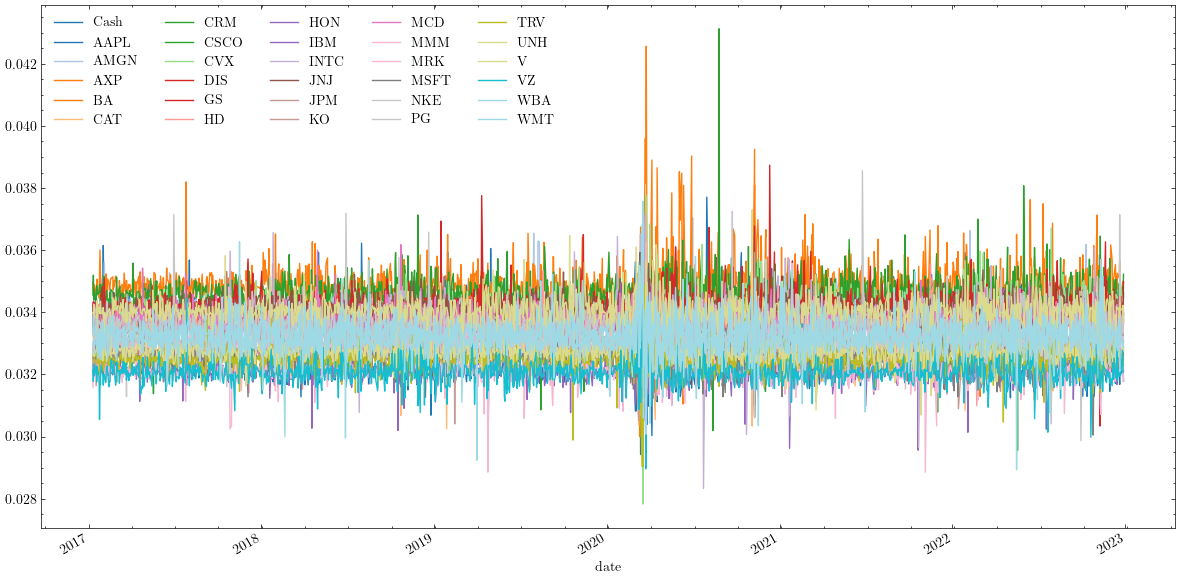

max drowdown: -0.32274258980341164 Sharp ratio: 0.7270892544556627


In [128]:
with plt.style.context('science','ieee'):
    # w.iloc[1:,].plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="summer").legend(ncol=5,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))
    weights.iloc[1:,].plot(x='date',figsize=(12,6),colormap="tab20")
    plt.legend(ncol=5, bbox_to_anchor=(0, 1), loc='upper left')
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()
    print('max drowdown:', qs.stats.max_drawdown(result_sac['test'][0].account) , 'Sharp ratio:', qs.stats.sharpe(result_sac['test'][0].daily_return))
